# BOF

In [2]:
%%html
<style>
    body {
        --vscode-font-family: 'AppleSDGothicNeoM00';
        line-height: 1.5;
        
    }
</style>

In [3]:
import os
print(os.getcwd())

import warnings
warnings.filterwarnings(action='ignore')  # 'default'

import gc
gc.collect()

import pandas as pd
# pd.set_option('display.max_rows', None)   # pd.options.display.max_rows = 60
pd.set_option('display.max_columns', None)  # pd.options.display.max_columns = 20

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'  # 'all'

from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/NanumGothic.TTF'  # 'C:/USERS/soono/AppData/Local/Microsoft/Windows/Fonts/AppleSDGothicNeoM.TTF'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font_name)

import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

# %matplotlib inline

c:\Users\soono\OneDrive\__Project__\AI-Spark-Global-Wildfire-Detection-Challenge\eda


In [4]:
import sys
from pathlib import Path

# print(sys.path)

current_dir = Path.cwd()
root_dir = current_dir.parent   # check whether project dir

if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# print(sys.path)

# Libs

In [5]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from PIL import Image

from skimage import io
from skimage.exposure import rescale_intensity

import tifffile as tiff

from copy import deepcopy
from pathlib import Path
import joblib
from tqdm import tqdm

In [6]:
import utils.getters as getters
import utils.savers as savers
import utils.visualizers as visers

from utils.getters import *
from utils.savers import *
from utils.visualizers import *

## Saver

In [7]:
import utils.savers as savers

print(savers.SAVE_DIR)

C:\Users\soono\OneDrive\__Project__\AI-Spark-Global-Wildfire-Detection-Challenge\eda\meta


In [8]:
# savers.save_mask_meta()
# savers.save_target_val()
# savers.save_out_meta()

## Loader

In [8]:
meta = pd.read_csv('meta/mask_meta.csv')
out = pd.read_csv('meta/out_meta.csv')

In [9]:
data = meta[~meta['mask'].isin(out['mask'])].reset_index(drop=True)
data.rename(columns={'mask': 'num',
                     'num_target': 'one'}, inplace=True)
data['one'] = data['one'].astype(int)

# Scaler

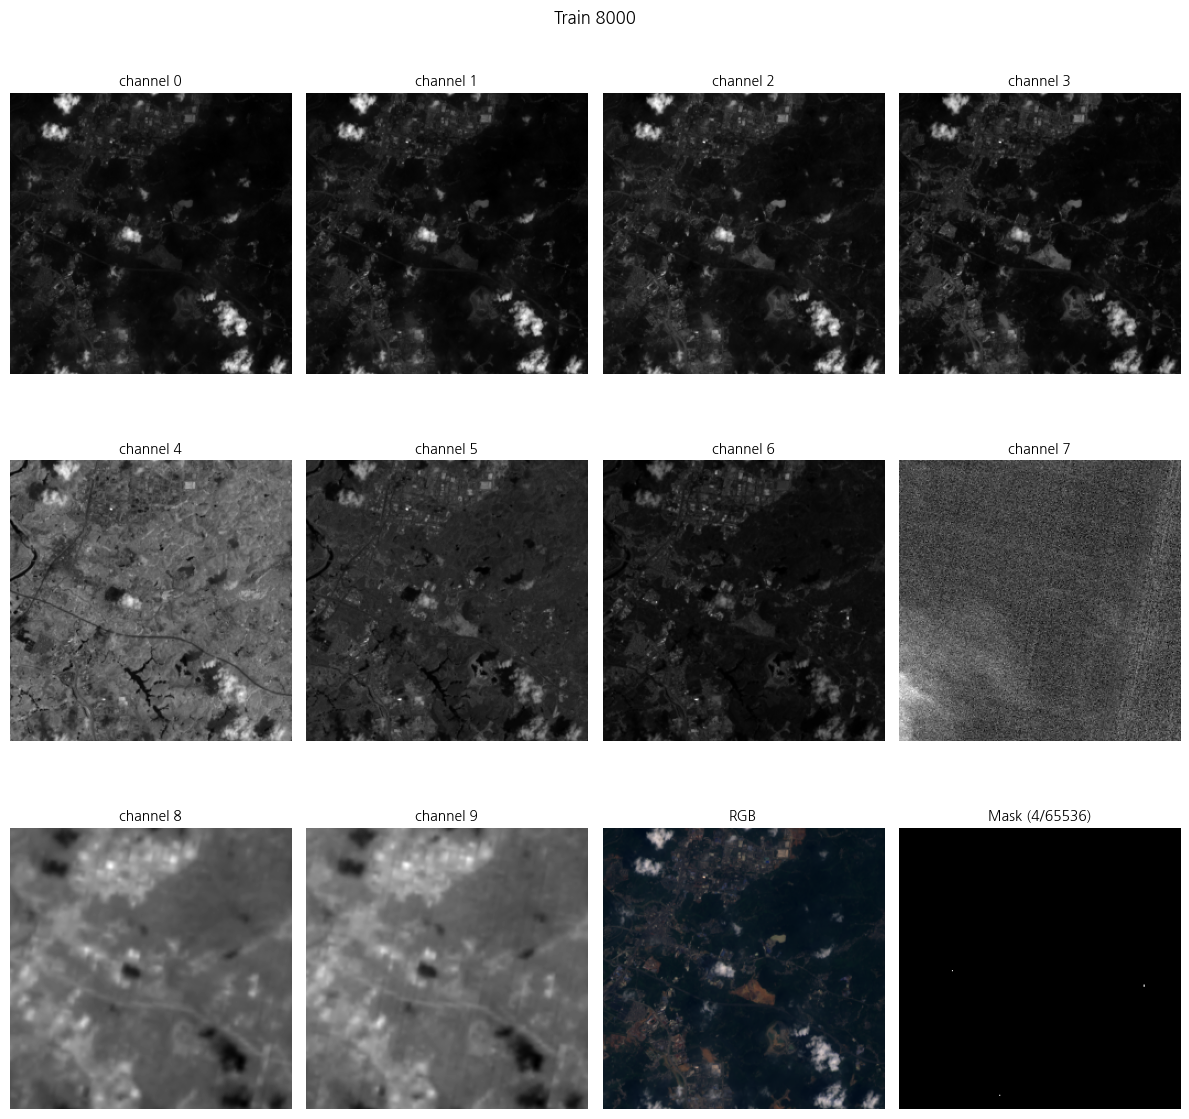

In [55]:
vis2(8000)

In [ ]:
img = tiff.imread(img_path)
img4 = img[:,:,4]
img5 = img[:,:,5]
img6 = img[:,:,6]

## Robust Scaling
img4s = (img4-np.percentile(img4,50))/(np.percentile(img4,75)-np.percentile(img4,25))
img5s = (img5-np.percentile(img5,50))/(np.percentile(img5,75)-np.percentile(img5,25))
img6s = (img6-np.percentile(img6,50))/(np.percentile(img6,75)-np.percentile(img6,25))
scale_value = img6s - img5s*0.8 - img4s*0.2
mask = np.where(scale_value>np.mean(scale_value)+np.std(scale_value)*12,1,0)

In [10]:
def get_error(scaler, nums):
    error_list, npsum_list = [], []
    for num in tqdm(nums):
        mask = getters._get_mask(num=num)
        scaled, npsum = scaler(num=num)
        
        correction = np.where(mask == scaled, 0, 1)
        error = (correction == 1).sum()
        error_list.append(error)
        
        npsum_list.append(npsum)
    
    return error_list, npsum_list


def base_scaler(num, chns=[4, 5, 6], thr=0.2):
    tif = get_tif(num, chns)
    
    mm_scaled = np.empty((3, 256, 256))
    for c in range(tif.shape[0]):
        tif_c = tif[c, :, :]
        minimum, maximum = tif_c.min(), tif_c.max()
        scaled = (tif_c - minimum) / (maximum - minimum)
        mm_scaled[c, :, :] = scaled
    
    sixp = mm_scaled[2, :, :] - mm_scaled[1, :, :] * 0.8 - mm_scaled[0, :, :] * 0.2   # 지형지물 지움
    sixp = np.where(sixp > thr, 1, 0)
    npsum = sixp.flatten().sum()
    
    return sixp, npsum


def robust_scaler(num, chns=[4, 5, 6], thr=12):
    tif = get_tif(num, chns)
    
    rb_scaled = np.empty((3, 256, 256))
    for c in range(tif.shape[0]):
        tif_c = tif[c, :, :]
        tif_cs = (tif_c - np.percentile(tif_c, 50)) / (np.percentile(tif_c, 75) - np.percentile(tif_c, 25))
        rb_scaled[c, :, :] = tif_cs
    
    sc_mask = rb_scaled[2, :, :] - rb_scaled[1, :, :] * 0.8 - rb_scaled[0, :, :] * 0.2
    sc_mask = np.where(sc_mask > np.mean(sc_mask) + np.std(sc_mask) * thr, 1, 0)
    
    return sc_mask

In [11]:
error_list, npsum_list = get_error(base_scaler, data['num'].values)

# data = data.sort_values(by='error', ascending=False)
# data = data.reset_index(drop=True)

100%|██████████| 30179/30179 [04:04<00:00, 123.55it/s]


In [28]:
data['error'] = error_list
data['npsum'] = npsum_list

In [33]:
data.to_csv('metadata/error_meta.csv', index=False)

In [34]:
data = pd.read_csv('metadata/error_meta.csv')

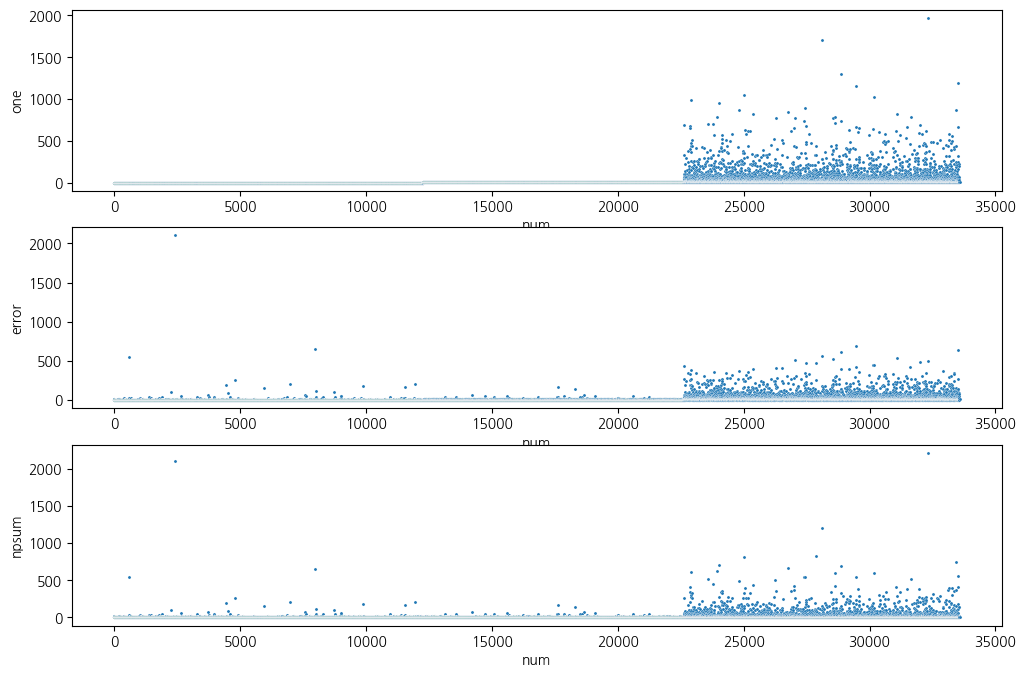

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 8))
sns.scatterplot(x='num', y='one', data=data,
                ax=ax1, s=5, palette='flare')
sns.scatterplot(x='num', y='error', data=data,
                ax=ax2, s=5, palette='flare')
sns.scatterplot(x='num', y='npsum', data=data,
                ax=ax3, s=5, palette='flare')
plt.show()

In [51]:
data.npsum.describe()

count    30179.000000
mean         7.152623
std         33.299973
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       2212.000000
Name: npsum, dtype: float64

In [50]:
data[data['npsum'] < 10].one.describe()

count    26661.000000
mean         8.474026
std          9.609782
min          3.000000
25%          4.000000
50%          5.000000
75%         10.000000
max        313.000000
Name: one, dtype: float64

In [46]:
"""
우리는 npsum 11 이하까지만 처리한다.
66, 75-25.
"""

count    30179.000000
mean         7.152623
std         33.299973
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       2212.000000
Name: npsum, dtype: float64

In [43]:
"""_summary_
npsum < 4 : 소형 산불
    소형 산불에서 robust scaling은 가중치를 12~16으로
"""

'_summary_\nnpsum < 4 : 소형 산불\n    소형 산불에서 robust scaling은 가중치를 12~16으로\n'

In [ ]:
data.error.describe()

In [ ]:
data.loc[(data['error'] < 10) &
         (data['one'] > 30)]

In [ ]:
data['hue'] = np.where(data['error'] > np.percentile(data['error'], 90), 0,
                       np.where(data['error'] > np.percentile(data['error'], 75), 1, 2))

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 10), nrows=2)
# sns.kdeplot(x='error', data=data, ax=ax)
sns.scatterplot(x='num', y='error', data=data,
                ax=ax1, hue='hue', s=5, palette='flare')
sns.scatterplot(x='num', y='error', data=data[data['hue'] == 2],
                ax=ax2, s=5)
plt.show()

In [ ]:
data.to_csv('error_meta.csv', index=False)

In [ ]:
data = pd.read_csv('error_meta.csv')

# More Visualizers

In [ ]:
def vis3(num, nrows=3, ncols=5):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 12))

    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row, col]

            # image = _get_tif(num)
            mask = getters._get_mask(num)
            idx = row * ncols + col
            
            # channels
            if idx <= 9:
                channel = idx
                cimg = getters._get_tif(num, channel)
                cimg = rescale_intensity(cimg, in_range=(cimg.min(), cimg.max()), out_range=(0, 1))

                ax.imshow(cimg, cmap='gray')
                ax.set_title(f'channel {channel}', fontsize=10)
            
            # RGB
            elif idx == 10:
                rgb = getters._get_tif(num, (3, 2, 1))
                rgb = rescale_intensity(rgb, in_range=(rgb.min(), rgb.max()), out_range=(0, 1))
                ax.imshow(rgb)
                ax.set_title('RGB', fontsize=10)
            
            # mask
            elif idx == 11:
                ax.imshow(mask, cmap='gray')
                # ax.set_title(f'Mask ({mask.flatten().sum()}/{(mask.shape[0] * mask.shape[1])})', fontsize=10)
                ax.set_title(f'Mask: {mask.flatten().sum()}', fontsize=10)
            
            # inference after minmax scaling, vs. real mask
            elif idx == 12:
                sixp = base_scaler(num)
                ax.imshow(sixp, cmap='gray')
                ax.set_title(f'#BaseScaled | #Pred: {sixp.flatten().sum()}', fontsize=10)
            elif idx == 13:
                correct_mat = np.where(mask == sixp, 0, 1)
                ax.imshow(correct_mat, cmap='gray')
                ax.set_title(f'Real vs. BaseSc | Error: {(correct_mat == 1).sum()}', fontsize=10)
            else:
                ax.set_visible(False)

            ax.axis('off')

    plt.suptitle(f'train_img_{num}')
    plt.tight_layout()
    plt.show()
    

In [ ]:
vis3(1)

In [ ]:
def vis4(nums: list | tuple | NDArray, ncols=4,
         channel: list | tuple | NDArray = (3, 2, 1),
         scaler=None, data=data, save=False):
    nrows = len(nums) // ncols if len(nums) % ncols == 0 else len(nums) // ncols + 1
    
    error_list = []
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 12))
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            ax = axes[row, col]
            
            if idx < len(nums):
                num = nums[idx]
                rgb = getters._get_tif(num=num, channel=channel)
                rgb = rescale_intensity(rgb, in_range=(rgb.min(), rgb.max()), out_range=(0, 1))
                ax.imshow(rgb)
                
                mask = getters._get_mask(num=num)
                one = mask.flatten().sum()
                # scaled = scaler(num=num)
                # correction = np.where(mask == scaled, 0, 1)
                # error = (correction == 1).sum()
                error = data.loc[data['num'] == num, 'error']
                error_list.append(error)
                
                ax.set_title(f'Image {num}\n#One: {one} | #Error: {error}', fontsize=10)
                ax.set_title(f'Image {num}\n#One: {one}', fontsize=10)
            else:
                ax.set_visible(False)
    
            ax.axis('off')
    
    # plt.suptitle(f'Image\n{nums}', fontsize=12, fontweight='semibold')
    # plt.suptitle(f'Channel {channel}', fontsize=12, fontweight='semibold')
    plt.tight_layout()
    
    if save:
        save_dir = savers.SAVE_DIR / f'channel_{channel}'
        save_dir.mkdir(parents=True, exist_ok=True)
        # save_name = f'error_{error_list[0]}_{error_list[-1]}.png'
        save_name = f'{nums[0]}_{nums[-1]}'
        save_path = str(save_dir / save_name)
        
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [ ]:
def save_vis4(metadata: pd.DataFrame = data, num_imgs=16):
    mok = len(metadata) // num_imgs
    nam = len(metadata) % 16
    
    for i in tqdm(range(mok)):
        if i != mok:
            vis4(metadata['num'].iloc[num_imgs*i:num_imgs*(i+1)].values, save=True)
        else:
            vis4(metadata['num'].iloc[num_imgs*mok:num_imgs*mok+nam].values, save=True)

In [ ]:
save_vis4()

# Ideas

In [ ]:
# 어차피 틀릴 것이라면, 1로 예측하는 것을 최대한 많게 하는 것이 유리하다.
# 1로 최대한 많이 예측하면 false positive도 늘어나겠지만 true positive도 늘어날 가능성이 높으니까.
# 0으로 예측해 틀리는 false negative는 분모만 늘어나게 하는 반면.

# Extra

In [ ]:
def mmscale(num, chns=[4, 5, 6], thr=0.1):
    img = get_tif(num, chns)
    sc = img[2, :, :] - img[1, :, :] * 0.5 - img[0, :, :] * 0.5
    # scm = np.where(sc > thr, 1, 0)
    
    # return scm
    return sc

In [ ]:
def rbscale(num, chns=[4, 5, 6], thr=16):
    scs = np.empty((3, 256, 256))
    for i, c in enumerate(chns):
        cn = get_tif(num, c)
        sc = (cn - np.percentile(cn, 50)) / (np.percentile(cn, 75) - np.percentile(cn, 25))
        scs[i, :, :] = sc
    
    sv = scs[2] * 2 - scs[1] - scs[0]
    
    sm = np.where(sv > np.mean(sv) + np.std(sv) * thr, 1, 0)
    
    # return sv, sm
    return sm

In [ ]:
m5 = [np.mean((rbscale(i) - np.mean(rbscale(i)))) ** 5 for i in tqdm([1, 1789, 1712, 32326])]

In [ ]:
# _, _ = tinfo(num=0, channel=5)
# _, _ = tinfo(1, 5)
# _, _ = tinfo(3221, 5)

In [ ]:
# 0, 1, 2, 3: 연기 + 구름
# 4, 5: 지형지물
# 6: 열
# 8, 9: 구름 (아마 구름이 연기보다 훨 차가움)

In [ ]:
## 전처리
# 일단 손날 치기 제외 (채널별 min이 모두 0이면 손날 치기)
    # 8, 9의 std로 구름 많은 거, 적은 거, 없는 거? 분할 하고
    # 4, 5로 작은 불, 중간 불, 큰 불 추가
    # 이걸로 그룹화를 하자. 
    # 문제
        # 9가지 그룹 중에서 이상치 그룹을 빼서 최종적으로 그룹을 3+-1 그룹으로 그룹화
        # 각각에 대해서 custom mask 채널을 다르게 만들어. (soft labeling)
        # 6 채널 + custom maks 채널 + x(6번 채널)
    # 제일 중요한 거: 소형 산불을 정확하게 맞추는 거임.

## 모델
# 그룹이 3~4개 나온다면... 특성에 맞게 다른 모델을 태울 것인데.. 작은 산물이면은 tiny object seg가 맞고. 큰 산불이면은 걍 seg
# transformer?